In [42]:
# from dataprocess.kdd_cup99 import KDD_CUP_99_DataLoader
from dataprocess.unsw_nb15 import UNSW_NB15_DataLoader
# from dataprocess.cic_ids_2017 import CIC_IDS_2107_DataLoader
from net.CNN import CNN3_4
# from net.multCNN import multCNN
# from net.FullConnect import linear3_dropout

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# from torch.utils.tensorboard import SummaryWriter

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from itertools import cycle
from numpy import interp

In [29]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='0'

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [30]:
# # for kdd_cup99
# dataset = KDD_CUP_99_DataLoader('E:/DataSets/kddcup.data', 256, 'Test')
# data_labels = dataset.data.to_num_column_dic[41].keys()
# class_num = len(data_labels)
# discrete_column_idx = dataset.data.discrete_column
# discrete_column_idx.remove(41)
# continuous_column_idx = [i for i in range(41) if i not in discrete_column_idx]
# input_channel_kind = len(discrete_column_idx)
# input_channel_num = len(continuous_column_idx)

# print(discrete_column_idx, continuous_column_idx, data_labels)

In [44]:
# for UNSW_NB15
dataset = UNSW_NB15_DataLoader('E:/DataSets/UNSW-NB15 - CSV Files', 256, 'Test')
data_labels = dataset.data.label_category.keys()
class_num = len(data_labels)
# discrete_column_idx = dataset.data.discrete_column
# discrete_column_idx.remove(47)
# discrete_column_idx.remove(48)
# continuous_column_idx = [i for i in range(47) if i not in discrete_column_idx]
# input_channel_kind = len(discrete_column_idx)
# input_channel_num = len(continuous_column_idx)
feature_length = dataset.data.feature_length

# hight, width = dataset.data.image_hight, dataset.data.image_width

print(data_labels, feature_length)

dict_keys([b'Normal', b'Generic', b'Exploits', b'Fuzzers', b'DoS', b'Reconnaissance', b'Analysis', b'Backdoors', b'Shellcode', b'Worms']) 218


In [ ]:
# columns = list(dataset.data.to_num_column_dic[4].keys())
# columns = [i.decode() for i in columns]
# for i in columns:
#     print(i)

In [32]:
# # for cic_ids2017
# batch_size =  256
# dataset = CIC_IDS_2107_DataLoader('E:/DataSets/CIC-IDS2016', batch_size, 'Test')
# data_labels = dataset.data.label_category.keys()
# class_num = len(data_labels)

# feature_length = dataset.data.feature_length
# print(class_num, feature_length)

9 85


In [33]:
# U2R_list = [b'loadmodule.', b'buffer_overflow.', b'perl.', b'rootkit.']
# # index = dataset.data.to_num_column_dic[41]
# # print(index)
# U2R_indices = [12, 16, 17, 21]

In [35]:
log_file = 'history/CNN3_4/CIC_IDS2017_UNSW_NB15_transfer_Adam_rebalance_rebalance_no_frozen/plot/confusion_matrix/5_14'
if not os.path.isdir(log_file):
    os.makedirs(log_file)

In [34]:
ckpt_file = 'history/CNN3_4/CIC_IDS2017_UNSW_NB15_transfer_Adam_rebalance_rebalance_no_frozen/checkpoint/5_14/ckpt_best_99.pth'
# net = CNN3_3(feature_length, class_num).to(device)

net = CNN3_4(feature_length, class_num).to(device)
checkpoint = torch.load(ckpt_file)
net.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [20]:
# # for kdd_dup99
# with torch.no_grad():
#     num = 0
#     num_dif = 0
#     for step, (x, y) in enumerate(dataset):
#         x_continuous, x_discrete =x[:, continuous_column_idx], x[:, discrete_column_idx]
#         x_continuous = x_continuous.to(device)
#         x_discrete = x_discrete.to(device)

#         y_pred = net((x_continuous, x_discrete))
#         y_pred = y_pred.cpu()

#         y_pred = torch.argmax(y_pred, 1)
#         U2R_select = (y == 12) + (y == 16) + (y == 17) + (y == 21)
#         y, y_pred = y[U2R_select], y_pred[U2R_select]
#         compare = y_pred != y
#         num += y_pred.shape[0]
#         num_dif += compare.sum().item()
# print(num, num_dif)

# accuracy = (num - num_dif) / num
# print(accuracy)

In [36]:
# for unsw_nb15
with torch.no_grad():
    num = 0
    num_dif = 0
    for step, (x, y) in enumerate(dataset):

        x = x.to(device)
        # y = F.one_hot(y.long(), num_classes=class_num).float()
        # y = y.view(y.shape[0], -1)

        y_pred = net(x)
        y_pred = y_pred.cpu()
        if step == 0:
            logits = np.array(y_pred)
            y_pred = torch.argmax(y_pred, 1)
            prediction = np.array(y_pred)
            y_1hot = np.array(y)
            y = torch.argmax(y, 1)
            label = np.array(y)
        else:
            logits = np.concatenate((logits, y_pred), axis=0)
            y_pred = torch.argmax(y_pred, 1)
            prediction = np.concatenate((prediction, y_pred), axis=0)
            y_1hot = np.concatenate((y_1hot, y),axis=0)
            y = torch.argmax(y, 1)
            label = np.concatenate((label, y), axis=0)
        # compare = y_pred != y
        # num += y_pred.shape[0]
        # num_dif += compare.sum().item()
# accuracy = (num - num_dif) / num
# print(accuracy)

In [37]:
print(np.unique(label))

[0 1 2 3 4 5 6 7 8]


In [38]:
# labels = [i.decode() for i in data_labels]
labels = list(data_labels)
print(classification_report(label, prediction, target_names=labels, zero_division=1))
with open(log_file + '/scores.txt','a') as print_log:
    print('\n##########  '+log_file+' ##########', file=print_log)
    print(classification_report(label, prediction, target_names=labels, zero_division=1), file=print_log)

              precision    recall  f1-score   support

      BENIGN       0.99      0.93      0.96     19908
         Bot       0.60      1.00      0.75       764
 Brute Force       0.98      1.00      0.99      5561
        DDoS       0.98      1.00      0.99     19982
         Dos       0.99      0.98      0.99     20028
  Heartbleed       0.80      1.00      0.89         4
Infiltration       0.12      1.00      0.21        11
    PortScan       0.99      0.99      0.99     19903
  Web Attack       0.69      0.99      0.82       879

    accuracy                           0.98     87040
   macro avg       0.80      0.99      0.84     87040
weighted avg       0.98      0.98      0.98     87040



In [39]:
cm = confusion_matrix(label, prediction)
acc = accuracy_score(label, prediction)

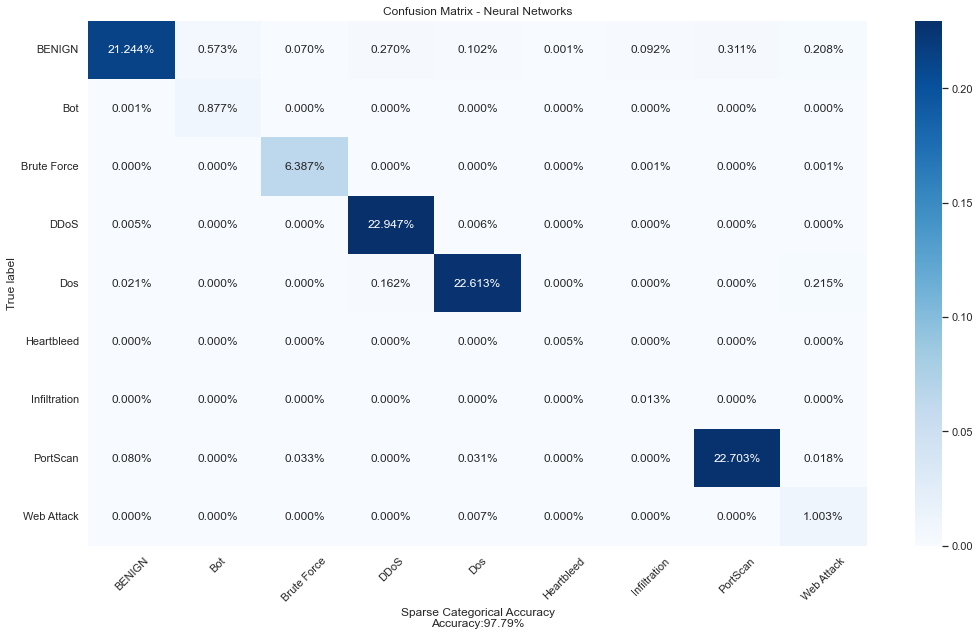

In [40]:
sns.set()
plt.figure(figsize=(15,9))
ax = sns.heatmap(cm/np.sum(cm),annot=True,fmt='.3%', cmap='Blues')
ax.set_title('Confusion Matrix - Neural Networks')
ax.set_xlabel(f'Sparse Categorical Accuracy\nAccuracy:{round(acc*100,2)}%')
ax.set_ylabel('True label')

ax.yaxis.set_ticklabels(labels)
ax.xaxis.set_ticklabels(labels)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(log_file+'/confusion_matrix')
plt.show()

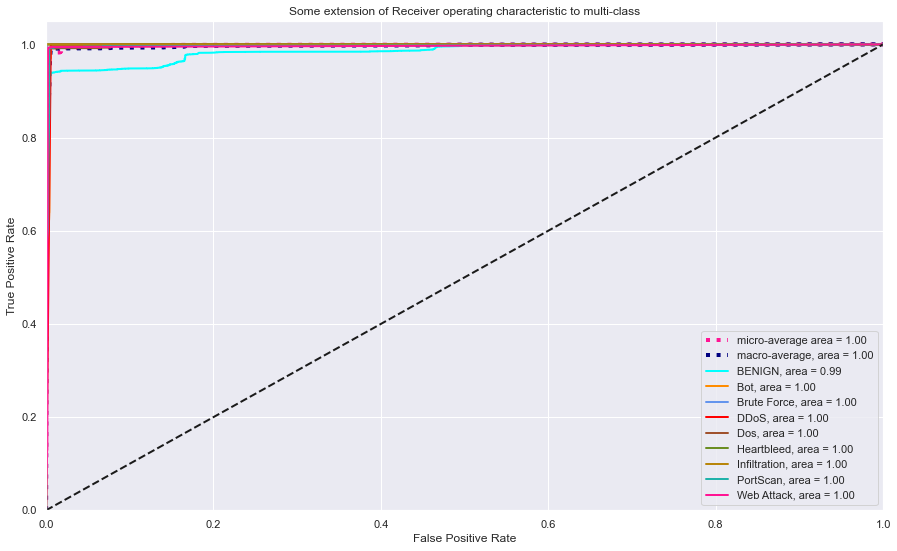

In [41]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(class_num):
    fpr[i], tpr[i], _ = roc_curve(y_1hot[:, i], logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_1hot.ravel(), logits.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_num)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(class_num):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= class_num
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure(figsize=(15,9))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average area = {0:0.2f}'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average, area = {0:0.2f}'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'sienna', 'olivedrab', 'darkgoldenrod', 'lightseagreen','deeppink', 'purple'])
for i, color in zip(range(class_num), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0}, area = {1:0.2f}'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig(log_file+'/ROC_curve')
plt.show()

In [ ]:
import torch
from torchviz import make_dot

x = torch.randn(20, 85)  # 随机生成一个张量
net_2 = linear3_Relu(feature_length, class_num)
out = net_2(x)   # 将 x 输入网络
g = make_dot(out)  # 实例化 make_dot
g.view()